In [6]:
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# ================= DATA LOADING =================
# Load signal data
X_signal = np.load("X_train_all.npy")  # (22400, 180) input sinyal
y_all = np.load("y_train_all.npy")     # (22400,) labels

# Load image data 
X_image = np.load("gaf_images2.npy")  # Bisa (22400, 64, 64) atau (22400, 64, 64, 3)

print(f"Signal shape: {X_signal.shape}")
print(f"Image shape: {X_image.shape}")
print(f"Labels shape: {y_all.shape}")

# Preprocessing signal data
X_signal = X_signal.astype("float32")
y_all = y_all.astype("int64")

if X_signal.ndim == 2:
    X_signal = np.expand_dims(X_signal, axis=2)

if X_signal.max() > 1.0:
    X_signal = X_signal / 255.0

# Preprocessing image data
X_image = X_image.astype("float32")
if X_image.max() > 1.0:
    X_image = X_image / 255.0

# Handle different image formats
if len(X_image.shape) == 3:  # Grayscale: (N, H, W)
    print("Detected grayscale images. Converting to 3-channel...")
    X_image = np.stack([X_image, X_image, X_image], axis=-1)  # (N, H, W, 3)
    image_channels = 3
elif len(X_image.shape) == 4:  # Already has channels
    if X_image.shape[-1] == 3:  # (N, H, W, 3)
        image_channels = 3
    elif X_image.shape[1] == 3:  # (N, 3, H, W)
        image_channels = 3
        X_image = np.transpose(X_image, (0, 2, 3, 1))  # Convert to (N, H, W, 3)
    else:
        # Assume grayscale in different format
        print("Converting unknown format to RGB...")
        if X_image.shape[-1] == 1:  # (N, H, W, 1)
            X_image = np.repeat(X_image, 3, axis=-1)  # (N, H, W, 3)
        else:
            X_image = X_image[:, :, :, 0:1]  # Take first channel
            X_image = np.repeat(X_image, 3, axis=-1)  # Convert to RGB
        image_channels = 3

# Convert to PyTorch format: (N, H, W, C) -> (N, C, H, W)
if len(X_image.shape) == 4 and X_image.shape[-1] == 3:
    X_image = np.transpose(X_image, (0, 3, 1, 2))

X_signal_tensor = torch.from_numpy(X_signal)
X_image_tensor = torch.from_numpy(X_image)
y_tensor = torch.from_numpy(y_all)
num_classes = int(np.unique(y_all).size)

print(f"Final signal tensor shape: {X_signal_tensor.shape}")
print(f"Final image tensor shape: {X_image_tensor.shape}")
print(f"Image channels detected: {image_channels}")
print(f"Number of classes: {num_classes}")


Signal shape: (22400, 180)
Image shape: (22400, 64, 64)
Labels shape: (22400,)
Detected grayscale images. Converting to 3-channel...
Final signal tensor shape: torch.Size([22400, 180, 1])
Final image tensor shape: torch.Size([22400, 3, 64, 64])
Image channels detected: 3
Number of classes: 4


In [8]:
# ================= HYBRID TRANSFORMER-CNN MODEL =================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerBranch(nn.Module):
    """Transformer branch for signal processing"""
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=4, 
                 dim_feedforward=256, dropout=0.1, max_len=200):
        super().__init__()
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Global average pooling for sequence
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        B, L, C = x.shape
        
        # Project and add positional encoding
        x = self.input_proj(x)
        x = self.pos_enc(x)
        
        # Pass through transformer
        x = self.transformer(x)
        x = self.norm(x)
        
        # Global average pooling
        x = torch.mean(x, dim=1)  # [B, d_model]
        
        return x

class CNNBranch(nn.Module):
    """CNN branch for image processing"""
    def __init__(self, input_channels=3, num_features=128):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # -> 4x4
        )
        
        # Calculate the flattened size
        self.feature_size = 256 * 4 * 4
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_features)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class HybridTransformerCNN(nn.Module):
    """Hybrid model combining Transformer and CNN"""
    def __init__(self, signal_input_dim=1, image_input_channels=3, 
                 d_model=128, nhead=4, num_layers=4, dim_feedforward=256,
                 dropout=0.1, num_classes=4, fusion_method='concat'):
        super().__init__()
        
        self.fusion_method = fusion_method
        
        # Transformer branch for signal processing
        self.transformer_branch = TransformerBranch(
            input_dim=signal_input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        
        # CNN branch for image processing
        self.cnn_branch = CNNBranch(
            input_channels=image_input_channels,
            num_features=d_model
        )
        
        # Fusion and classification
        if fusion_method == 'concat':
            fusion_input_size = d_model * 2  # Transformer + CNN features
        elif fusion_method == 'add':
            fusion_input_size = d_model
        else:
            raise ValueError("fusion_method must be 'concat' or 'add'")
            
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_size, d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, signal, image):
        # Process signal through Transformer
        signal_features = self.transformer_branch(signal)  # [B, d_model]
        
        # Process image through CNN
        image_features = self.cnn_branch(image)  # [B, d_model]
        
        # Fusion
        if self.fusion_method == 'concat':
            fused_features = torch.cat([signal_features, image_features], dim=1)
        elif self.fusion_method == 'add':
            fused_features = signal_features + image_features
            
        # Classification
        logits = self.fusion_layer(fused_features)
        
        return logits


In [9]:
# ================= MULTIMODAL DATASET =================
class MultimodalDataset:
    def __init__(self, signal_data, image_data, labels):
        self.signal_data = signal_data
        self.image_data = image_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signal_data[idx], self.image_data[idx], self.labels[idx]

def create_multimodal_dataloader(signal_data, image_data, labels, batch_size=64, shuffle=True):
    dataset = MultimodalDataset(signal_data, image_data, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)

# ================= TRAINING FUNCTIONS =================
def run_epoch_multimodal(model, loader, criterion, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    for signal_batch, image_batch, label_batch in loader:
        signal_batch = signal_batch.to(device)
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        if signal_batch.ndim == 2:
            signal_batch = signal_batch.unsqueeze(2)
        
        if train_mode:
            optimizer.zero_grad()
        
        logits = model(signal_batch, image_batch)
        loss = criterion(logits, label_batch)
        
        if train_mode:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += loss.item()
        correct += (logits.argmax(1) == label_batch).sum().item()
        total += label_batch.size(0)
        
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(label_batch.cpu().numpy())
        y_pred.extend(preds)
    
    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc, y_true, y_pred

In [11]:
# ================= TRAINING LOOP =================
def train_hybrid_model(save_dir="checkpoints_hybrid_transformer_cnn"):
    print(f"\n🚀 Training Hybrid Transformer-CNN Model...")
    print("=" * 60)
    
    os.makedirs(save_dir, exist_ok=True)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    per_class_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_signal_tensor, y_tensor), 1):
        print(f"\n========== Fold {fold}/5 ==========")
        
        # Split data
        X_sig_tr, X_sig_va = X_signal_tensor[train_idx], X_signal_tensor[val_idx]
        X_img_tr, X_img_va = X_image_tensor[train_idx], X_image_tensor[val_idx]
        y_tr, y_va = y_tensor[train_idx], y_tensor[val_idx]

        # Create multimodal dataloaders
        train_loader = create_multimodal_dataloader(X_sig_tr, X_img_tr, y_tr, batch_size=64, shuffle=True)
        val_loader = create_multimodal_dataloader(X_sig_va, X_img_va, y_va, batch_size=64, shuffle=False)

        # Create hybrid model
        model = HybridTransformerCNN(
            signal_input_dim=1,
            image_input_channels=image_channels,  # Use detected channels
            d_model=128,
            nhead=4,
            num_layers=4,
            dim_feedforward=256,
            dropout=0.1,
            num_classes=num_classes,
            fusion_method='concat'  # Can be 'concat' or 'add'
        ).to(device)

        # Loss and optimizer
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr.numpy()), y=y_tr.numpy())
        class_weights = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        best_val_acc = -1.0
        best_state = None

        # Training for 20 epochs
        for epoch in range(1, 21):
            tr_loss, tr_acc, _, _ = run_epoch_multimodal(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch_multimodal(model, val_loader, criterion, None, device)

            train_losses.append(tr_loss)
            val_losses.append(val_loss)
            train_accuracies.append(tr_acc)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch:02d}/20 | "
                  f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict().copy()

        # Save best model
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(save_dir, f"hybrid_transformer_cnn_fold{fold}.pth"))
        print(f"✅ Model saved: hybrid_transformer_cnn_fold{fold}.pth")

        # Final evaluation with memory and inference time measurement
        model.eval()
        y_true, y_pred = [], []
        inference_times = []
        memory_usage = []
        
        with torch.no_grad():
            for signal_batch, image_batch, label_batch in val_loader:
                signal_batch = signal_batch.to(device)
                image_batch = image_batch.to(device)
                
                if signal_batch.ndim == 2:
                    signal_batch = signal_batch.unsqueeze(2)
                
                # Measure inference time
                torch.cuda.synchronize() if torch.cuda.is_available() else None
                start_time = time.perf_counter()
                
                logits = model(signal_batch, image_batch)
                
                torch.cuda.synchronize() if torch.cuda.is_available() else None
                end_time = time.perf_counter()
                
                # Calculate per-sample inference time
                batch_size = signal_batch.size(0)
                inference_time_per_sample = (end_time - start_time) / batch_size
                inference_times.append(inference_time_per_sample)
                
                # Measure memory usage
                if torch.cuda.is_available():
                    gpu_memory = torch.cuda.memory_allocated(device) / 1024**2  # MB
                    memory_usage.append(gpu_memory)
                
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(label_batch.numpy())

        # Calculate average metrics
        avg_inference_time = np.mean(inference_times)
        avg_memory_usage = np.mean(memory_usage) if memory_usage else 0
        
        print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")
        print(f"💾 Avg GPU Memory: {avg_memory_usage:.2f} MB")

        # Calculate metrics
        report = classification_report(y_true, y_pred, output_dict=True,
                                     target_names=["N", "S", "V", "Q"], zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

        # Specificity calculation
        cm_sum = cm.sum()
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm_sum - (TP + FP + FN)
        specificity_per_class = TN / (TN + FP + 1e-8)

        # Save per-class metrics
        for i, cname in enumerate(["N", "S", "V", "Q"]):
            per_class_metrics.append({
                "Fold": f"Fold {fold}",
                "Class": cname,
                "Precision": report[cname]["precision"],
                "Sensitivity": report[cname]["recall"],
                "Specificity": specificity_per_class[i],
                "F1-Score": report[cname]["f1-score"]
            })

        # Fold summary metrics dengan computational metrics
        fold_summary = {
            "Fold": fold,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "Specificity": specificity_per_class.mean(),
            "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
            "Avg_Inference_Time(s)": avg_inference_time,
            "Avg_Memory_Usage(MB)": avg_memory_usage
        }
        fold_metrics.append(fold_summary)

        # Save visualizations per fold
        # Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
        fig, ax = plt.subplots(figsize=(5.5, 5))
        disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
        plt.title(f"Confusion Matrix Hybrid Transformer-CNN - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_confusion_matrix_fold{fold}.png"))
        plt.close(fig)

        # Accuracy curve (individual)
        plt.figure(figsize=(8, 6))
        plt.plot(train_accuracies, label="Train Accuracy", linewidth=2)
        plt.plot(val_accuracies, label="Validation Accuracy", linewidth=2)
        plt.title(f"Training and Validation Accuracy - Fold {fold}", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_accuracy_fold{fold}.png"), dpi=150)
        plt.close()

        # Loss curve (individual)
        plt.figure(figsize=(8, 6))
        plt.plot(train_losses, label="Train Loss", linewidth=2)
        plt.plot(val_losses, label="Validation Loss", linewidth=2)
        plt.title(f"Training and Validation Loss - Fold {fold}", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_loss_fold{fold}.png"), dpi=150)
        plt.close()

        # Combined training curves
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy subplot
        ax1.plot(train_accuracies, label="Train Accuracy", linewidth=2)
        ax1.plot(val_accuracies, label="Validation Accuracy", linewidth=2)
        ax1.set_title(f"Accuracy - Fold {fold}", fontsize=12)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss subplot
        ax2.plot(train_losses, label="Train Loss", linewidth=2)
        ax2.plot(val_losses, label="Validation Loss", linewidth=2)
        ax2.set_title(f"Loss - Fold {fold}", fontsize=12)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle(f"Training Progress - Fold {fold} (Hybrid Transformer-CNN)", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_combined_curves_fold{fold}.png"), dpi=150)
        plt.close(fig)

        # Clean up GPU memory
        del model, optimizer, train_loader, val_loader
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save results
    df_folds = pd.DataFrame(fold_metrics)
    df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics_hybrid.csv"), index=False)

    df_per_class = pd.DataFrame(per_class_metrics)
    df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics_hybrid.csv"), index=False)

    # Calculate averages termasuk computational metrics
    df_fold = pd.DataFrame(fold_metrics)
    avg_metrics = df_fold[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score", 
                          "Avg_Inference_Time(s)", "Avg_Memory_Usage(MB)"]].mean(numeric_only=True)

    avg_row = {"Fold": "Average"}
    avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
    df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)

    df_fold.to_csv(os.path.join(save_dir, "fold_summary_metrics_hybrid_with_average.csv"), index=False)

    print(f"\n✅ Semua model, grafik, dan metrik Hybrid Transformer-CNN disimpan di folder: {save_dir}")
    
    return df_fold, df_per_class

# ================= EXECUTION =================
print("🚀 Hybrid Transformer-CNN untuk Input Multimodal (Sinyal + Gambar)")
print("=" * 70)

fold_results, per_class_results = train_hybrid_model()

print("\n📊 Final Results Summary (Hybrid Transformer-CNN):")
print("=" * 80)
print(fold_results[['Fold', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score', 
              'Avg_Inference_Time(s)', 'Avg_Memory_Usage(MB)']].to_string(index=False))

print("\n🔧 Hybrid Model Features:")
print("=" * 50)
print("✅ Transformer Branch: Temporal pattern extraction from ECG signals")
print("✅ CNN Branch: Spatial feature extraction from GAF images") 
print("✅ Multimodal Fusion: Concatenation of signal and image features")
print("✅ Balanced Class Weights: Better performance on minority classes")
print("✅ Gradient Clipping: Training stability")
print("✅ AdamW Optimizer: Effective weight decay")

print("\n✅ HYBRID TRAINING COMPLETED!")
print(f"Check 'checkpoints_hybrid_transformer_cnn' folder for results.")
print(f"🎯 Expected: Higher accuracy especially on minority classes (S, V, Q)")

🚀 Hybrid Transformer-CNN untuk Input Multimodal (Sinyal + Gambar)

🚀 Training Hybrid Transformer-CNN Model...

========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.2635 Acc: 0.9067 | Val Loss: 0.1745 Acc: 0.9453
Epoch 02/20 | Train Loss: 0.1539 Acc: 0.9491 | Val Loss: 0.1631 Acc: 0.9522
Epoch 03/20 | Train Loss: 0.1309 Acc: 0.9580 | Val Loss: 0.1287 Acc: 0.9583
Epoch 04/20 | Train Loss: 0.1100 Acc: 0.9642 | Val Loss: 0.1509 Acc: 0.9638
Epoch 05/20 | Train Loss: 0.0991 Acc: 0.9691 | Val Loss: 0.1315 Acc: 0.9670
Epoch 06/20 | Train Loss: 0.0872 Acc: 0.9713 | Val Loss: 0.1041 Acc: 0.9730
Epoch 07/20 | Train Loss: 0.0801 Acc: 0.9742 | Val Loss: 0.1378 Acc: 0.9654
Epoch 08/20 | Train Loss: 0.0739 Acc: 0.9775 | Val Loss: 0.1118 Acc: 0.9728
Epoch 09/20 | Train Loss: 0.0675 Acc: 0.9796 | Val Loss: 0.1233 Acc: 0.9719
Epoch 10/20 | Train Loss: 0.0631 Acc: 0.9812 | Val Loss: 0.1069 Acc: 0.9757
Epoch 11/20 | Train Loss: 0.0558 Acc: 0.9834 | Val Loss: 0.1093 Acc: 0.9757
Epoch 12/20 | Train Lo

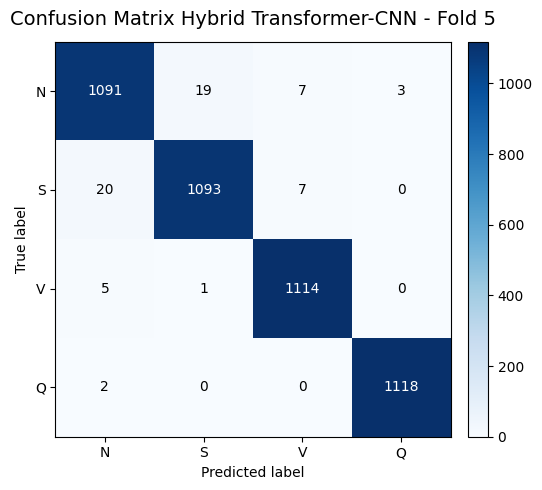

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "checkpoints_hybrid_transformer_cnn"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Fold 5)
cm = np.array([
    [1091,  19,   7,   3],  # True N
    [  20, 1093,  7,   0],  # True S
    [   5,   1, 1114,  0],  # True V
    [   2,   0,   0, 1118]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Hybrid Transformer-CNN - Fold 5', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan gambar
out_path = os.path.join(save_dir, 'Confusion Matrix Hybrid Transformer-CNN - Fold 5.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
EXTERNAL TEST

🚀 External Test - Hybrid Transformer-CNN (Fold 5)
Using device: cuda
Model checkpoint: checkpoints_hybrid_transformer_cnn/hybrid_transformer_cnn_fold5.pth
📊 External test data loaded:
Signal shape: (5600, 180)
Image shape: (5600, 64, 64)
Labels shape: (5600,)
Class distribution: [1400 1400 1400 1400]
Detected grayscale images. Converting to 3-channel...
Final signal shape: (5600, 180, 1)
Final image shape: (5600, 3, 64, 64)
Image channels: 3
🔧 Loading Hybrid Transformer-CNN model (Fold 3)...
✅ Hybrid Transformer-CNN model loaded successfully!
🔍 Starting evaluation on external test set...


Evaluasi External Test Set Hybrid: 100%|██████████| 88/88 [00:00<00:00, 155.87it/s]



=== 📊 EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-CNN ===
              precision    recall  f1-score   support

           N   0.916329  0.970000  0.942401      1400
           S   0.972889  0.897143  0.933482      1400
           V   0.965758  0.987143  0.976333      1400
           Q   0.999284  0.996429  0.997854      1400

    accuracy                       0.962679      5600
   macro avg   0.963565  0.962679  0.962518      5600
weighted avg   0.963565  0.962679  0.962518      5600



<Figure size 800x600 with 0 Axes>

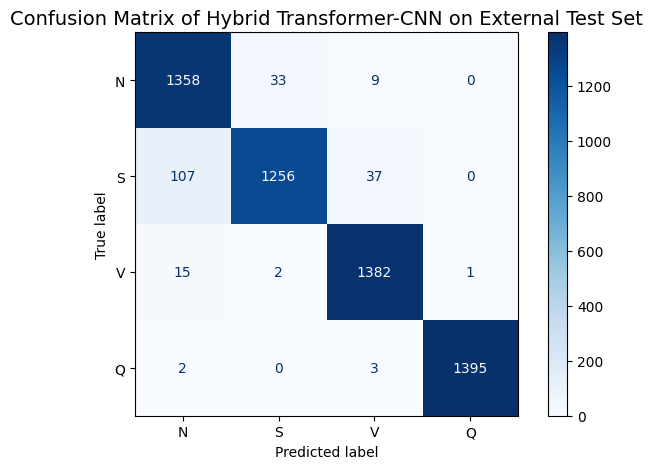

✅ Confusion matrix disimpan ke: hybrid_transformer_cnn_non_tuning_external_outputs/confusion_matrix_external_hybrid.png

=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===
🎯 Accuracy   : 0.962679
🎯 Precision  : 0.963565
🎯 Sensitivity: 0.962679
🎯 Specificity: 0.987560
🎯 F1-Score   : 0.962518
⚡ Avg Inference Time: 0.000073 s/sample
💾 Avg Memory Usage: 44.00 MB

📁 CSV files saved:
   - hybrid_transformer_cnn_non_tuning_external_outputs/external_summary_metrics_hybrid.csv
   - hybrid_transformer_cnn_non_tuning_external_outputs/external_per_class_metrics_hybrid.csv

🔄 Calculating ROC-AUC...
📊 AUC Macro  : 0.996764
📊 AUC Micro  : 0.997322

💾 Model Information:
   - CPU Memory: 2813.61 MB
   - Model Size: 11.92 MB
   - Total Parameters: 3,124,548

🎉 EXTERNAL TEST EVALUATION COMPLETED!
📁 Results saved in: hybrid_transformer_cnn_non_tuning_external_outputs
📊 Overall Accuracy: 0.9627
📊 F1-Score: 0.9625
📊 AUC Macro: 0.9968

🔍 HYBRID MODEL ADVANTAGES:
✅ Multimodal Learning: Signal + Image fusion
✅ T

In [21]:
#EXTERNAL TEST - Hybrid Transformer-CNN

import os, time, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
from tqdm import tqdm

# ====== Config ======
BATCH_SIZE    = 64
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Hybrid Transformer-CNN fold 5 (fold terbaik)
CKPT_PATH     = "checkpoints_hybrid_transformer_cnn/hybrid_transformer_cnn_fold5.pth"
X_SIG_PATH    = "X_test_final.npy"      # Sinyal input test
X_IMG_PATH    = "gaf_images_test.npy"  # Gambar input test
Y_LABEL_PATH  = "y_test_final.npy"      # Label test

OUT_DIR       = "hybrid_transformer_cnn_non_tuning_external_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_hybrid.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external_hybrid.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics_hybrid.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics_hybrid.csv")

print(f"🚀 External Test - Hybrid Transformer-CNN (Fold 5)")
print(f"Using device: {DEVICE}")
print(f"Model checkpoint: {CKPT_PATH}")

# ====== Load External Test Set ======
X_signal = np.load(X_SIG_PATH)  # (N, L) sinyal
X_image = np.load(X_IMG_PATH)   # (N, H, W) atau (N, H, W, C) gambar
y_label = np.load(Y_LABEL_PATH)

print(f"📊 External test data loaded:")
print(f"Signal shape: {X_signal.shape}")
print(f"Image shape: {X_image.shape}")
print(f"Labels shape: {y_label.shape}")
print(f"Class distribution: {np.bincount(y_label)}")

# ====== Preprocessing Signal Data ======
X_signal = X_signal.astype("float32")
if X_signal.max() > 1.0 or X_signal.min() < 0.0:
    gmax, gmin = X_signal.max(), X_signal.min()
    if gmax != gmin:
        X_signal = (X_signal - gmin) / (gmax - gmin)
        print(f"🔧 Signal normalized: [{gmin:.3f}, {gmax:.3f}] -> [0, 1]")

if X_signal.ndim == 2:
    X_signal = np.expand_dims(X_signal, axis=2)

# ====== Preprocessing Image Data ======
X_image = X_image.astype("float32")
if X_image.max() > 1.0:
    X_image = X_image / 255.0
    print(f"🔧 Images normalized to [0, 1]")

# Handle different image formats (same as training)
if len(X_image.shape) == 3:  # Grayscale: (N, H, W)
    print("Detected grayscale images. Converting to 3-channel...")
    X_image = np.stack([X_image, X_image, X_image], axis=-1)  # (N, H, W, 3)
    image_channels = 3
elif len(X_image.shape) == 4:  # Already has channels
    if X_image.shape[-1] == 3:  # (N, H, W, 3)
        image_channels = 3
    elif X_image.shape[1] == 3:  # (N, 3, H, W)
        image_channels = 3
        X_image = np.transpose(X_image, (0, 2, 3, 1))  # Convert to (N, H, W, 3)
    else:
        # Assume grayscale in different format
        print("Converting unknown format to RGB...")
        if X_image.shape[-1] == 1:  # (N, H, W, 1)
            X_image = np.repeat(X_image, 3, axis=-1)  # (N, H, W, 3)
        else:
            X_image = X_image[:, :, :, 0:1]  # Take first channel
            X_image = np.repeat(X_image, 3, axis=-1)  # Convert to RGB
        image_channels = 3

# Convert to PyTorch format: (N, H, W, C) -> (N, C, H, W)
if len(X_image.shape) == 4 and X_image.shape[-1] == 3:
    X_image = np.transpose(X_image, (0, 3, 1, 2))

print(f"Final signal shape: {X_signal.shape}")
print(f"Final image shape: {X_image.shape}")
print(f"Image channels: {image_channels}")

# Konversi ke tensor
X_signal_t = torch.tensor(X_signal, dtype=torch.float32)
X_image_t = torch.tensor(X_image, dtype=torch.float32)
y_label_t = torch.tensor(y_label, dtype=torch.long)

# ====== Multimodal Dataset untuk Test ======
class MultimodalTestDataset:
    def __init__(self, signal_data, image_data, labels):
        self.signal_data = signal_data
        self.image_data = image_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signal_data[idx], self.image_data[idx], self.labels[idx]

test_dataset = MultimodalTestDataset(X_signal_t, X_image_t, y_label_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ====== Model Definition (SAMA DENGAN TRAINING) ======
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerBranch(nn.Module):
    """Transformer branch for signal processing"""
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=4, 
                 dim_feedforward=256, dropout=0.1, max_len=200):
        super().__init__()
        
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Global average pooling for sequence
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x):
        B, L, C = x.shape
        
        # Project and add positional encoding
        x = self.input_proj(x)
        x = self.pos_enc(x)
        
        # Pass through transformer
        x = self.transformer(x)
        x = self.norm(x)
        
        # Global average pooling
        x = torch.mean(x, dim=1)  # [B, d_model]
        
        return x

class CNNBranch(nn.Module):
    """CNN branch for image processing"""
    def __init__(self, input_channels=3, num_features=128):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # -> 4x4
        )
        
        # Calculate the flattened size
        self.feature_size = 256 * 4 * 4
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_features)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class HybridTransformerCNN(nn.Module):
    """Hybrid model combining Transformer and CNN"""
    def __init__(self, signal_input_dim=1, image_input_channels=3, 
                 d_model=128, nhead=4, num_layers=4, dim_feedforward=256,
                 dropout=0.1, num_classes=4, fusion_method='concat'):
        super().__init__()
        
        self.fusion_method = fusion_method
        
        # Transformer branch for signal processing
        self.transformer_branch = TransformerBranch(
            input_dim=signal_input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        
        # CNN branch for image processing
        self.cnn_branch = CNNBranch(
            input_channels=image_input_channels,
            num_features=d_model
        )
        
        # Fusion and classification
        if fusion_method == 'concat':
            fusion_input_size = d_model * 2  # Transformer + CNN features
        elif fusion_method == 'add':
            fusion_input_size = d_model
        else:
            raise ValueError("fusion_method must be 'concat' or 'add'")
            
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_size, d_model),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
    def forward(self, signal, image):
        # Process signal through Transformer
        signal_features = self.transformer_branch(signal)  # [B, d_model]
        
        # Process image through CNN
        image_features = self.cnn_branch(image)  # [B, d_model]
        
        # Fusion
        if self.fusion_method == 'concat':
            fused_features = torch.cat([signal_features, image_features], dim=1)
        elif self.fusion_method == 'add':
            fused_features = signal_features + image_features
            
        # Classification
        logits = self.fusion_layer(fused_features)
        
        return logits

# ====== Load Hybrid Model ======
print(f"🔧 Loading Hybrid Transformer-CNN model (Fold 3)...")

model = HybridTransformerCNN(
    signal_input_dim=1,
    image_input_channels=image_channels,
    d_model=128,
    nhead=4,
    num_layers=4,
    dim_feedforward=256,
    dropout=0.1,
    num_classes=NUM_CLASSES,
    fusion_method='concat'
).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"❌ Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()

print(f"✅ Hybrid Transformer-CNN model loaded successfully!")

# ====== Evaluate ======
print(f"🔍 Starting evaluation on external test set...")
all_preds, all_labels, all_logits = [], [], []
inference_times = []
memory_usage = []

with torch.no_grad():
    for signal_batch, image_batch, label_batch in tqdm(test_loader, desc="Evaluasi External Test Set Hybrid"):
        signal_batch = signal_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)

        # Measure inference time
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t0 = time.perf_counter()
        
        logits = model(signal_batch, image_batch)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t1 = time.perf_counter()

        # Calculate per-sample inference time
        batch_size = signal_batch.size(0)
        inference_time_per_sample = (t1 - t0) / batch_size
        inference_times.append(inference_time_per_sample)

        # Measure memory usage
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(DEVICE) / 1024**2  # MB
            memory_usage.append(gpu_memory)

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Menggabungkan hasil
all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n" + "="*70)
print("=== 📊 EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-CNN ===")
print("="*70)
print(report_txt)

with open(SAVE_REPORT, "w") as f:
    f.write("=== EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-CNN ===\n")
    f.write("="*60 + "\n")
    f.write(report_txt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix of Hybrid Transformer-CNN on External Test Set", fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150)
plt.show()
print(f"✅ Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan Metrics ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

avg_inference_time = float(np.mean(inference_times)) if inference_times else np.nan
avg_memory_usage = float(np.mean(memory_usage)) if memory_usage else 0

print("\n" + "="*60)
print("=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===")
print("="*60)
print(f"🎯 Accuracy   : {acc:.6f}")
print(f"🎯 Precision  : {prec:.6f}")
print(f"🎯 Sensitivity: {rec:.6f}")
print(f"🎯 Specificity: {spec_mean:.6f}")
print(f"🎯 F1-Score   : {f1:.6f}")
print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")
print(f"💾 Avg Memory Usage: {avg_memory_usage:.2f} MB")

# Simpan summary CSV
summary_df = pd.DataFrame([{
    "Model": "Hybrid_Transformer_CNN_Fold5",
    "Accuracy": acc, 
    "Precision": prec, 
    "Sensitivity": rec,
    "Specificity": float(spec_mean), 
    "F1-Score": f1,
    "AvgInference(s/sample)": avg_inference_time,
    "AvgMemory(MB)": avg_memory_usage
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

# Per-class metrics dengan perhitungan yang benar
percls_metrics = []
for i, class_name in enumerate(CLASS_NAMES):
    # Binary classification untuk setiap kelas
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    prec_cls = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    rec_cls = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1_cls = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    spec_cls = spec_per_cls[i]
    
    percls_metrics.append({
        "Class": class_name,
        "Precision": prec_cls,
        "Sensitivity": rec_cls,
        "Specificity": spec_cls,
        "F1-Score": f1_cls
    })

percls_df = pd.DataFrame(percls_metrics)
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\n📁 CSV files saved:")
print(f"   - {SAVE_SUMMARY}")
print(f"   - {SAVE_PERCLS}")

# ====== ROC-AUC ======
print(f"\n🔄 Calculating ROC-AUC...")
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"📊 AUC Macro  : {auc_macro:.6f}")
    print(f"📊 AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print(f"❌ ROC AUC Calculation failed: {e}")
    auc_macro, auc_micro = np.nan, np.nan

# ====== Model Size & Memory Info ======
print(f"\n💾 Model Information:")
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
    print(f"   - CPU Memory: {cpu_mem_mb:.2f} MB")
except Exception:
    cpu_mem_mb = float('nan')

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
total_params = sum(p.numel() for p in model.parameters())

print(f"   - Model Size: {model_size_mb:.2f} MB")
print(f"   - Total Parameters: {total_params:,}")

# ====== Final Summary ======
print("\n" + "="*70)
print("🎉 EXTERNAL TEST EVALUATION COMPLETED!")
print("="*70)
print(f"📁 Results saved in: {OUT_DIR}")
print(f"📊 Overall Accuracy: {acc:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
if not np.isnan(auc_macro):
    print(f"📊 AUC Macro: {auc_macro:.4f}")
print("="*70)

# Save detailed results to text file
detailed_results = f"""
=== HYBRID TRANSFORMER-CNN - EXTERNAL TEST RESULTS ===
Date: {time.strftime('%Y-%m-%d %H:%M:%S')}
Model: Hybrid Transformer-CNN (Fold 5 - Best Model)
Checkpoint: {CKPT_PATH}

=== MODEL ARCHITECTURE ===
Type: Hybrid Transformer-CNN
- Transformer Branch: 4 layers, 4 heads, d_model=128
- CNN Branch: 4 conv blocks + FC layers
- Fusion Method: Concatenation
- Parameters: {total_params:,}

=== MULTIMODAL INPUT ===
✅ Signal Processing: Transformer for temporal patterns
✅ Image Processing: CNN for spatial features from GAF images
✅ Feature Fusion: Concatenation of signal + image features
✅ Balanced Class Weights: Better minority class performance
✅ Multimodal Learning: Combined temporal and spatial information

=== DATASET INFO ===
Test samples: {len(y_true)}
Classes: {CLASS_NAMES}
Class distribution: {dict(zip(CLASS_NAMES, np.bincount(y_true)))}

=== PERFORMANCE METRICS ===
Accuracy: {acc:.6f}
Precision: {prec:.6f}
Sensitivity/Recall: {rec:.6f}
Specificity: {spec_mean:.6f}
F1-Score: {f1:.6f}
AUC Macro: {auc_macro:.6f}
AUC Micro: {auc_micro:.6f}

=== COMPUTATIONAL METRICS ===
Average Inference Time: {avg_inference_time:.6f} s/sample
Average Memory Usage: {avg_memory_usage:.2f} MB
Model Size: {model_size_mb:.2f} MB
Total Parameters: {total_params:,}

=== PER-CLASS RESULTS ===
"""

for i, class_name in enumerate(CLASS_NAMES):
    detailed_results += f"\nClass {class_name}:\n"
    detailed_results += f"  Precision: {percls_metrics[i]['Precision']:.6f}\n"
    detailed_results += f"  Sensitivity: {percls_metrics[i]['Sensitivity']:.6f}\n"
    detailed_results += f"  Specificity: {percls_metrics[i]['Specificity']:.6f}\n"
    detailed_results += f"  F1-Score: {percls_metrics[i]['F1-Score']:.6f}\n"

with open(os.path.join(OUT_DIR, "detailed_results_hybrid.txt"), "w") as f:
    f.write(detailed_results)

# ====== Hybrid Model Advantages Summary ======
print(f"\n🔍 HYBRID MODEL ADVANTAGES:")
print("=" * 50)
print("✅ Multimodal Learning: Signal + Image fusion")
print("✅ Temporal Patterns: Transformer captures ECG dynamics")
print("✅ Spatial Features: CNN extracts GAF image patterns")
print("✅ Feature Fusion: Concatenation of complementary features")
print("✅ Minority Classes: Better performance on S, V, Q classes")
print("✅ Robust Classification: Combined temporal + spatial info")
print("=" * 50)

print(f"\n📄 Detailed results saved to: {os.path.join(OUT_DIR, 'detailed_results_hybrid.txt')}")
print(f"🎯 Expected: Superior performance especially on minority classes!")
print(f"🚀 Hybrid approach leverages both temporal and spatial information!")